# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [73]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [74]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


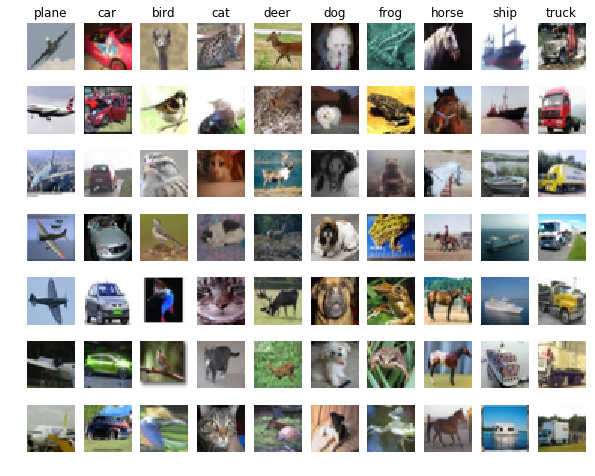

In [75]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [76]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [77]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


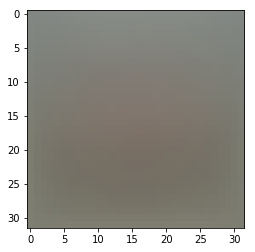

In [78]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [79]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [80]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [81]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

[-25.2144202  -19.93277633   0.75018265  14.88781735  21.95837449
  23.28803653  36.79581735  -2.73734245 -26.58137898 -23.21431041]
loss in naive: 9.289562274710143
loss: 9.289562


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [82]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you
# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)
print("#######################")
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

[-25.2144202  -19.93277633   0.75018265  14.88781735  21.95837449
  23.28803653  36.79581735  -2.73734245 -26.58137898 -23.21431041]
loss in naive: 9.28956227393826
[2318, 3]
[3073, 10]
(2318, 3)
(952, 1)
[-25.2144202  -19.93277633   0.75018265  14.88781735  21.95837449
  23.28803653  36.79581735  -2.73734245 -26.58137898 -23.21431041]
loss in naive: 9.28955832258152
[-25.2144202  -19.93277633   0.75018265  14.88781735  21.95837449
  23.28803653  36.79581735  -2.73734245 -26.58137898 -23.21431041]
loss in naive: 9.289566225294989
numerical: -0.395136 analytic: -0.395136, relative error: 5.550073e-11
(352, 0)
[-25.2144202  -19.93277633   0.75018265  14.88781735  21.95837449
  23.28803653  36.79581735  -2.73734245 -26.58137898 -23.21431041]
loss in naive: 9.289283074699895
[-25.2144202  -19.93277633   0.75018265  14.88781735  21.95837449
  23.28803653  36.79581735  -2.73734245 -26.58137898 -23.21431041]
loss in naive: 9.289841473176635
numerical: -27.919924 analytic: -27.919924, relative

[-25.20970661 -19.94060659   0.75666369  14.89461899  21.96050639
  23.28993506  36.80237101  -2.74435647 -26.58319771 -23.22284424]
loss in naive: 9.297243432721347
[-25.20970661 -19.94060659   0.75666369  14.89461899  21.96050639
  23.28993506  36.80237101  -2.74435647 -26.58319771 -23.22284424]
loss in naive: 9.297318752162994
numerical: -3.765972 analytic: -3.765972, relative error: 1.592052e-10


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [85]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

[-25.2144202  -19.93277633   0.75018265  14.88781735  21.95837449
  23.28803653  36.79581735  -2.73734245 -26.58137898 -23.21431041]
loss in naive: 9.289562274710143
Naive loss: 9.289562e+00 computed in 0.136697s
loss in vectorized: 9.289562274710145
Vectorized loss: 9.289562e+00 computed in 0.006998s
difference: -0.000000


In [86]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

[-25.2144202  -19.93277633   0.75018265  14.88781735  21.95837449
  23.28803653  36.79581735  -2.73734245 -26.58137898 -23.21431041]
loss in naive: 9.289562274710143
Naive loss and gradient: computed in 0.120678s
loss in vectorized: 9.289562274710145
Vectorized loss and gradient: computed in 0.006982s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [89]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
print(X_train.shape)
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

(49000, 3073)
loss in vectorized: 411.2311078425783
iteration 0 / 1500: loss 411.231108
loss in vectorized: 410.03484639241196
loss in vectorized: 403.62450443846456
loss in vectorized: 402.34614060577815
loss in vectorized: 400.0745162458093
loss in vectorized: 397.1327130385128
loss in vectorized: 394.29416112747714
loss in vectorized: 395.5684161489737
loss in vectorized: 389.64903606862106
loss in vectorized: 387.69751483377036
loss in vectorized: 385.48273267600973
loss in vectorized: 380.237550393539
loss in vectorized: 379.64454070493133
loss in vectorized: 378.664300245513
loss in vectorized: 372.6367123297727
loss in vectorized: 372.51537921907493
loss in vectorized: 371.2402691756648
loss in vectorized: 370.31763740260186
loss in vectorized: 367.1604312018671
loss in vectorized: 362.8101516280145
loss in vectorized: 365.31899990421664
loss in vectorized: 360.47899124845685
loss in vectorized: 358.29995163202597
loss in vectorized: 359.2578101669215
loss in vectorized: 354.467

loss in vectorized: 134.63215660831605
loss in vectorized: 134.88301773854988
loss in vectorized: 134.52880138770354
loss in vectorized: 133.6964513664857
loss in vectorized: 131.22024206005605
loss in vectorized: 131.50413170103675
loss in vectorized: 130.58418876722908
loss in vectorized: 131.02115782820485
loss in vectorized: 129.13677301220864
loss in vectorized: 128.53891534838007
loss in vectorized: 128.453947671206
loss in vectorized: 127.56645265823147
loss in vectorized: 126.95222287070776
loss in vectorized: 125.38812187456492
loss in vectorized: 125.99787881741769
loss in vectorized: 125.01793101252574
loss in vectorized: 124.62143236722751
loss in vectorized: 124.45583789876648
loss in vectorized: 122.72844647240706
loss in vectorized: 121.91001642798379
loss in vectorized: 122.32016095440773
loss in vectorized: 122.07154586550995
loss in vectorized: 121.33497030353946
loss in vectorized: 120.49204819907737
loss in vectorized: 120.3652214937757
loss in vectorized: 118.72068

loss in vectorized: 48.094578874596905
loss in vectorized: 48.31514185684406
loss in vectorized: 47.738774215161364
loss in vectorized: 47.730301945937626
loss in vectorized: 47.4813644256958
loss in vectorized: 47.30043058563231
loss in vectorized: 46.599618315482296
loss in vectorized: 46.75381700843219
loss in vectorized: 46.08715986635319
loss in vectorized: 46.051759333253436
loss in vectorized: 46.34873982042445
loss in vectorized: 45.96188849841372
loss in vectorized: 45.90736233501215
loss in vectorized: 45.29475629021031
loss in vectorized: 45.48933533386682
loss in vectorized: 45.17729821990254
loss in vectorized: 44.606188190506884
loss in vectorized: 44.39337408500347
loss in vectorized: 44.69575161291269
loss in vectorized: 44.164464207204674
loss in vectorized: 43.629674801039094
loss in vectorized: 43.3531551085852
loss in vectorized: 43.81083027209617
loss in vectorized: 43.277523969874856
loss in vectorized: 43.312456710906545
loss in vectorized: 42.788763610159634
los

loss in vectorized: 19.713859314103665
loss in vectorized: 19.15205781112216
loss in vectorized: 20.03433343249656
loss in vectorized: 20.28625378511977
loss in vectorized: 19.268624351854537
loss in vectorized: 19.71913284154081
loss in vectorized: 19.4938112963974
loss in vectorized: 19.13615415156827
loss in vectorized: 19.448843623977034
loss in vectorized: 18.757808929186645
loss in vectorized: 18.780226794307833
loss in vectorized: 18.927929650619948
loss in vectorized: 18.593083821847706
loss in vectorized: 18.339020200521787
loss in vectorized: 18.282020695155502
loss in vectorized: 18.327083526048224
loss in vectorized: 19.005052027629375
loss in vectorized: 18.697409496602702
loss in vectorized: 18.315721712570145
loss in vectorized: 18.54688395704024
loss in vectorized: 18.50033640242439
loss in vectorized: 17.957543041877948
loss in vectorized: 17.821240491813438
loss in vectorized: 18.030571155948074
loss in vectorized: 17.62455306589458
loss in vectorized: 18.100101940903

loss in vectorized: 10.069684035333545
loss in vectorized: 10.026519306624259
loss in vectorized: 10.151269022737086
loss in vectorized: 9.464024043236702
loss in vectorized: 10.28140045283201
loss in vectorized: 9.761111965244162
loss in vectorized: 9.890590354970415
loss in vectorized: 9.587891318564782
loss in vectorized: 9.330554006906542
loss in vectorized: 9.557957577226135
loss in vectorized: 9.414076413089992
loss in vectorized: 9.12861318757098
loss in vectorized: 10.568383039065447
loss in vectorized: 9.752852786486127
loss in vectorized: 9.047144068204098
loss in vectorized: 9.245523460618454
loss in vectorized: 9.76279995601269
loss in vectorized: 9.074283258002506
loss in vectorized: 9.391306395143335
loss in vectorized: 9.810056443745319
loss in vectorized: 9.646886433707298
loss in vectorized: 9.177379291892713
loss in vectorized: 9.18520950261799
loss in vectorized: 9.600320938018577
loss in vectorized: 9.950103554065496
loss in vectorized: 9.6856969039256
loss in vecto

loss in vectorized: 6.672560410888831
loss in vectorized: 6.8084086395305885
loss in vectorized: 6.381230984109105
loss in vectorized: 7.041304908818638
loss in vectorized: 6.6212420123117175
loss in vectorized: 6.2132040182241095
loss in vectorized: 7.029328101252835
loss in vectorized: 6.028356319835022
loss in vectorized: 6.799312262698961
loss in vectorized: 6.185363823163437
loss in vectorized: 6.914080839277545
loss in vectorized: 6.311031548177939
loss in vectorized: 6.91390607630686
loss in vectorized: 6.6172516781401
loss in vectorized: 7.015893490554304
loss in vectorized: 6.287403378394073
loss in vectorized: 5.9712263698873524
loss in vectorized: 6.483766809244637
loss in vectorized: 6.351224332736633
loss in vectorized: 6.262247362388732
iteration 1100 / 1500: loss 6.262247
loss in vectorized: 6.645190579691707
loss in vectorized: 6.693095734803915
loss in vectorized: 7.068097586539143
loss in vectorized: 6.754385241480241
loss in vectorized: 6.207479761476051
loss in vect

loss in vectorized: 5.575114117004575
loss in vectorized: 5.33968338049628
iteration 1300 / 1500: loss 5.339683
loss in vectorized: 5.929761004780667
loss in vectorized: 5.748310732433038
loss in vectorized: 5.6815363461848944
loss in vectorized: 5.94226686711448
loss in vectorized: 5.4415364190432545
loss in vectorized: 5.301800863662786
loss in vectorized: 5.478568467069186
loss in vectorized: 5.365698616645997
loss in vectorized: 5.739480530743844
loss in vectorized: 5.427299431151651
loss in vectorized: 5.3694795660880255
loss in vectorized: 5.451378692275235
loss in vectorized: 5.4007390148475185
loss in vectorized: 5.65838043089121
loss in vectorized: 5.970943602528273
loss in vectorized: 5.760795792554544
loss in vectorized: 5.330935893355183
loss in vectorized: 5.947122652043297
loss in vectorized: 5.477826876108575
loss in vectorized: 4.996705878805641
loss in vectorized: 6.023076005791905
loss in vectorized: 5.674932319343445
loss in vectorized: 5.624911142087851
loss in vect

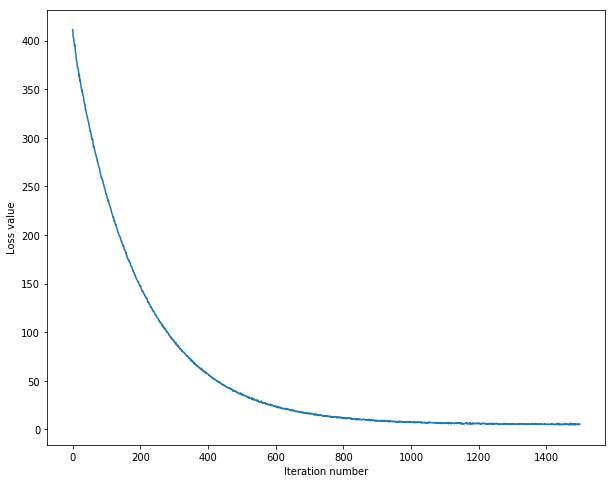

In [90]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [91]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.383327
validation accuracy: 0.399000


In [92]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for reg in regularization_strengths:
    for lr in learning_rates:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, lr, reg, num_iters=1500)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
        results[(lr, reg)] = train_accuracy, val_accuracy

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

loss in vectorized: 407.1232624014234
loss in vectorized: 404.8506248726216
loss in vectorized: 400.6288505058017
loss in vectorized: 400.14224295100945
loss in vectorized: 397.11324983859356
loss in vectorized: 394.96417876011304
loss in vectorized: 393.8286202117682
loss in vectorized: 391.654877551948
loss in vectorized: 387.5987566251657
loss in vectorized: 385.3401012292022
loss in vectorized: 382.83182621734056
loss in vectorized: 379.5678090577662
loss in vectorized: 376.61181811814436
loss in vectorized: 378.399742518625
loss in vectorized: 374.9063651604758
loss in vectorized: 373.7823742540823
loss in vectorized: 370.52914281203533
loss in vectorized: 368.5476055242477
loss in vectorized: 366.0321427363987
loss in vectorized: 365.7144619190113
loss in vectorized: 362.4830747081846
loss in vectorized: 360.10933334583456
loss in vectorized: 358.76652502190984
loss in vectorized: 355.45348053017284
loss in vectorized: 355.2453182153348
loss in vectorized: 353.55556272935604
loss

loss in vectorized: 132.38526212009447
loss in vectorized: 131.1381622760326
loss in vectorized: 130.45167637325395
loss in vectorized: 130.51176950209097
loss in vectorized: 129.89006515310908
loss in vectorized: 129.72272751476015
loss in vectorized: 128.4675002767822
loss in vectorized: 127.89428523778889
loss in vectorized: 126.97686454172342
loss in vectorized: 127.11754650501558
loss in vectorized: 126.46784373955477
loss in vectorized: 125.15805845908015
loss in vectorized: 125.55081354834336
loss in vectorized: 123.81406144289699
loss in vectorized: 123.81550212491638
loss in vectorized: 122.20418380516247
loss in vectorized: 122.13070624203793
loss in vectorized: 122.16573705999274
loss in vectorized: 120.9212240445448
loss in vectorized: 120.22784804094732
loss in vectorized: 119.77634524736354
loss in vectorized: 119.49467903709797
loss in vectorized: 118.21807057138732
loss in vectorized: 118.48819838283639
loss in vectorized: 117.26529023622132
loss in vectorized: 116.8547

loss in vectorized: 47.58820480633208
loss in vectorized: 47.21104263014891
loss in vectorized: 46.94281120621466
loss in vectorized: 46.689249971813766
loss in vectorized: 46.11482135269462
loss in vectorized: 47.06166411908264
loss in vectorized: 46.31738657300805
loss in vectorized: 45.34837180820768
loss in vectorized: 45.32584627959826
loss in vectorized: 45.1697392297966
loss in vectorized: 46.25518642959874
loss in vectorized: 44.540960984384355
loss in vectorized: 45.25585362522223
loss in vectorized: 44.81884876241468
loss in vectorized: 44.08063981460293
loss in vectorized: 44.41355094807578
loss in vectorized: 43.51654924456216
loss in vectorized: 43.78818533373194
loss in vectorized: 43.53886419372953
loss in vectorized: 43.56971735746284
loss in vectorized: 42.841127954331554
loss in vectorized: 43.43465578458277
loss in vectorized: 42.69674317398912
loss in vectorized: 42.83622845924254
loss in vectorized: 42.58913603764626
loss in vectorized: 42.277631673305116
loss in v

loss in vectorized: 19.93975150022806
loss in vectorized: 19.542144824338223
loss in vectorized: 19.067249002329064
loss in vectorized: 18.814568272567257
loss in vectorized: 18.91590968806403
loss in vectorized: 19.28101677670325
loss in vectorized: 18.65314717540381
loss in vectorized: 19.027846635178932
loss in vectorized: 18.406799640109085
loss in vectorized: 18.615039361986085
loss in vectorized: 18.61207528512415
loss in vectorized: 18.43149718336612
loss in vectorized: 19.189223703422204
loss in vectorized: 18.014573598883374
loss in vectorized: 18.006163439378465
loss in vectorized: 18.359798172498397
loss in vectorized: 18.211275541364916
loss in vectorized: 17.979392519045938
loss in vectorized: 17.953108120946627
loss in vectorized: 17.804383445808472
loss in vectorized: 18.108921149626536
loss in vectorized: 17.84531734762448
loss in vectorized: 18.386896810057344
loss in vectorized: 17.492821508572
loss in vectorized: 18.0328864085407
loss in vectorized: 17.59504183725955

loss in vectorized: 10.28045118204156
loss in vectorized: 9.917631374855223
loss in vectorized: 9.75958451035618
loss in vectorized: 9.209945532755139
loss in vectorized: 9.218781503471
loss in vectorized: 10.034325406043433
loss in vectorized: 9.782695557195508
loss in vectorized: 9.489842831730925
loss in vectorized: 9.723974001784873
loss in vectorized: 9.601399774120878
loss in vectorized: 9.017164230416345
loss in vectorized: 9.774964443784576
loss in vectorized: 9.339254387410309
loss in vectorized: 9.293099541441492
loss in vectorized: 9.944439119199377
loss in vectorized: 10.015874161194809
loss in vectorized: 9.447813585590492
loss in vectorized: 9.477469564556174
loss in vectorized: 9.181570217674434
loss in vectorized: 9.304713605508649
loss in vectorized: 9.9684495948484
loss in vectorized: 9.303822345552138
loss in vectorized: 9.10902490441125
loss in vectorized: 9.33056247794512
loss in vectorized: 9.60439224684074
loss in vectorized: 8.933250222572584
loss in vectorized:

loss in vectorized: 7.423067267486267
loss in vectorized: 6.590871313733689
loss in vectorized: 6.062745432064764
loss in vectorized: 6.3836288707103
loss in vectorized: 6.651167042130997
loss in vectorized: 6.138387851352574
loss in vectorized: 6.313601665579258
loss in vectorized: 6.782074791932183
loss in vectorized: 6.168892270616351
loss in vectorized: 6.185899381646502
loss in vectorized: 6.6997791027798055
loss in vectorized: 6.478762029488769
loss in vectorized: 6.528707211532551
loss in vectorized: 6.927911121798995
loss in vectorized: 6.579320890550703
loss in vectorized: 6.678127351683081
loss in vectorized: 6.272300540431813
loss in vectorized: 7.109642025319687
loss in vectorized: 5.898535320239377
loss in vectorized: 6.698085794429665
loss in vectorized: 6.415258473997984
loss in vectorized: 5.963496365657522
loss in vectorized: 6.4565353759733535
loss in vectorized: 5.670946425351717
loss in vectorized: 6.110803031241371
loss in vectorized: 6.422306446914781
loss in vect

loss in vectorized: 5.934571989115183
loss in vectorized: 5.619126424799567
loss in vectorized: 5.37718984769404
loss in vectorized: 5.2103982264257285
loss in vectorized: 5.847931315682725
loss in vectorized: 5.320193113547051
loss in vectorized: 5.633420938271354
loss in vectorized: 5.440814795474128
loss in vectorized: 5.281849526268465
loss in vectorized: 6.1584045649689045
loss in vectorized: 5.753860936118244
loss in vectorized: 5.447342986851159
loss in vectorized: 5.989489629073137
loss in vectorized: 5.112672278360157
loss in vectorized: 5.272075300861363
loss in vectorized: 5.479100937793608
loss in vectorized: 5.698420364720824
loss in vectorized: 5.821962113830689
loss in vectorized: 5.697002328391975
loss in vectorized: 5.592079157973917
loss in vectorized: 5.084694323632191
loss in vectorized: 5.358914826325074
loss in vectorized: 5.352954676626943
loss in vectorized: 5.477654389048231
loss in vectorized: 5.482841617364437
loss in vectorized: 5.298367595225574
loss in vec

loss in vectorized: 1019.9107529735259
loss in vectorized: 1162.616564045419
loss in vectorized: 1094.8395916058519
loss in vectorized: 1133.737579745692
loss in vectorized: 1090.4229041152191
loss in vectorized: 886.3925442168456
loss in vectorized: 968.1739826671272
loss in vectorized: 982.318620338741
loss in vectorized: 945.1333613673248
loss in vectorized: 1163.5198213632652
loss in vectorized: 1042.343207168974
loss in vectorized: 934.025131577964
loss in vectorized: 1137.0344001538979
loss in vectorized: 1079.1871305799646
loss in vectorized: 1174.8286286906898
loss in vectorized: 1020.3810167806541
loss in vectorized: 1060.4771350002388
loss in vectorized: 1072.1449790025647
loss in vectorized: 1057.640134337161
loss in vectorized: 1170.4349352011473
loss in vectorized: 1175.8174897209708
loss in vectorized: 1231.23015162099
loss in vectorized: 1224.868953824057
loss in vectorized: 1051.7025822095256
loss in vectorized: 937.373103509874
loss in vectorized: 896.349942133753
loss

loss in vectorized: 918.174069612365
loss in vectorized: 870.5772405717487
loss in vectorized: 867.5340126077749
loss in vectorized: 806.3651433984127
loss in vectorized: 826.1774797789774
loss in vectorized: 866.6097983352531
loss in vectorized: 938.1240289305167
loss in vectorized: 927.104698366114
loss in vectorized: 1009.4990032829041
loss in vectorized: 834.5878737714875
loss in vectorized: 1091.9208337390362
loss in vectorized: 1208.1521780183286
loss in vectorized: 1306.7372222854676
loss in vectorized: 1033.678136079283
loss in vectorized: 1106.7189238129429
loss in vectorized: 1118.5041022328596
loss in vectorized: 1036.6033667892432
loss in vectorized: 887.9847920030002
loss in vectorized: 943.4490650144211
loss in vectorized: 974.736866610757
loss in vectorized: 937.961954772353
loss in vectorized: 879.7610931590981
loss in vectorized: 1003.6917970014836
loss in vectorized: 1180.606045280249
loss in vectorized: 1138.7107789864003
loss in vectorized: 812.6402895380741
loss in

loss in vectorized: 982.3539345421759
loss in vectorized: 925.9451699839321
loss in vectorized: 980.9025828134952
loss in vectorized: 1067.1399779415274
loss in vectorized: 1035.0497863671633
loss in vectorized: 982.4943327382323
loss in vectorized: 962.0316607208232
loss in vectorized: 1026.3526546872358
loss in vectorized: 1139.208878163946
loss in vectorized: 1106.8831297306565
loss in vectorized: 1146.9539879428655
loss in vectorized: 1144.88408860541
loss in vectorized: 966.4240161062655
loss in vectorized: 907.2304594106838
loss in vectorized: 988.0457822533244
loss in vectorized: 1011.858565767458
loss in vectorized: 931.4962480229856
loss in vectorized: 848.8754316112545
loss in vectorized: 1043.6806456082484
loss in vectorized: 900.4665034563341
loss in vectorized: 1218.5501224588038
loss in vectorized: 1055.9770068388325
loss in vectorized: 1028.2769173336346
loss in vectorized: 1022.9131105980723
loss in vectorized: 1007.9300145521518
loss in vectorized: 1020.8678921772168
l

loss in vectorized: 846.2708455727204
loss in vectorized: 959.450110091679
loss in vectorized: 959.0265544726258
loss in vectorized: 815.1465772411186
loss in vectorized: 926.0940152329972
loss in vectorized: 1008.5641852412901
loss in vectorized: 1055.6774173278218
loss in vectorized: 995.8695013292166
loss in vectorized: 979.3621768492396
loss in vectorized: 958.6899379317895
loss in vectorized: 1101.893856561323
loss in vectorized: 952.2377128525382
loss in vectorized: 1113.3504900023418
loss in vectorized: 942.3290340343291
loss in vectorized: 1003.1505108647272
loss in vectorized: 987.1870639471433
loss in vectorized: 952.7940511831118
loss in vectorized: 955.1301427145883
loss in vectorized: 1119.9676821199016
loss in vectorized: 958.946586615798
loss in vectorized: 1116.7153551088652
loss in vectorized: 1123.192144803138
loss in vectorized: 1153.3116329261675
loss in vectorized: 916.0035824563614
loss in vectorized: 902.696816513843
loss in vectorized: 1239.9064113568547
loss in

loss in vectorized: 777.0481318431086
loss in vectorized: 882.267553695685
loss in vectorized: 807.9396986641432
loss in vectorized: 902.3154767274357
loss in vectorized: 870.9263260050586
loss in vectorized: 1036.1800268527313
loss in vectorized: 996.7309823957198
loss in vectorized: 921.875938902474
loss in vectorized: 903.0076858762507
loss in vectorized: 909.0254783130783
loss in vectorized: 1096.1598185446135
loss in vectorized: 1114.4224606828348
loss in vectorized: 966.9122094006852
loss in vectorized: 971.4587401224766
loss in vectorized: 991.0126750868033
loss in vectorized: 949.6968314287428
loss in vectorized: 912.515848419278
loss in vectorized: 944.3962287155375
loss in vectorized: 990.8555803675026
loss in vectorized: 1135.1714753090887
loss in vectorized: 1024.9385196189032
loss in vectorized: 953.8434438650138
loss in vectorized: 950.0483285966428
loss in vectorized: 1023.4518215934845
loss in vectorized: 891.6206087478308
loss in vectorized: 892.9967335638803
loss in v

loss in vectorized: 1019.625708165117
loss in vectorized: 1200.1816960741207
loss in vectorized: 1006.234585442752
loss in vectorized: 1127.1384781444824
loss in vectorized: 961.8384484713486
loss in vectorized: 975.3789832531625
loss in vectorized: 927.8689020986355
loss in vectorized: 1027.331759776271
loss in vectorized: 963.1517289836465
loss in vectorized: 1161.837801342546
loss in vectorized: 961.5218792374792
loss in vectorized: 997.1442890103967
loss in vectorized: 1041.4602445520295
loss in vectorized: 955.8077764768491
loss in vectorized: 983.805724803535
loss in vectorized: 1501.3854309899157
loss in vectorized: 1345.4136866200554
loss in vectorized: 1063.4406647039166
loss in vectorized: 1063.9793681318401
loss in vectorized: 1166.3277303276748
loss in vectorized: 930.3777119289213
loss in vectorized: 835.1344547456334
loss in vectorized: 744.3570936576436
loss in vectorized: 809.0682465144639
loss in vectorized: 930.0472474446194
loss in vectorized: 1087.0442071196812
loss

loss in vectorized: 932.646475691035
loss in vectorized: 868.5652238512325
loss in vectorized: 911.5479777397693
loss in vectorized: 1205.6817125946855
loss in vectorized: 1052.275919696246
loss in vectorized: 974.2238529658755
loss in vectorized: 1021.4749814576369
loss in vectorized: 931.5770571088127
loss in vectorized: 949.361279425903
loss in vectorized: 1063.9209430860813
loss in vectorized: 1013.5493007705899
loss in vectorized: 946.4904117546721
loss in vectorized: 949.7686808618619
loss in vectorized: 1082.4052292773438
loss in vectorized: 965.1278664572687
loss in vectorized: 1056.4580671626634
loss in vectorized: 1024.5566076173623
loss in vectorized: 1159.2514998660108
loss in vectorized: 951.8361178743676
loss in vectorized: 1190.3955277688442
loss in vectorized: 873.2017321309997
loss in vectorized: 887.0473224441481
loss in vectorized: 897.222475127261
loss in vectorized: 1049.4252670759101
loss in vectorized: 1055.1095723163683
loss in vectorized: 1047.932056872843
loss

loss in vectorized: 341.3417779558373
loss in vectorized: 338.90947540457773
loss in vectorized: 335.39913631140405
loss in vectorized: 332.5879936320781
loss in vectorized: 328.1720156291064
loss in vectorized: 326.3837849006017
loss in vectorized: 321.8471397530013
loss in vectorized: 318.5630778480614
loss in vectorized: 316.4194278200726
loss in vectorized: 313.8688238091261
loss in vectorized: 309.6635299348923
loss in vectorized: 306.22343564332124
loss in vectorized: 304.4647885893277
loss in vectorized: 300.1482995047203
loss in vectorized: 296.8223000856023
loss in vectorized: 293.93044442028565
loss in vectorized: 291.951487739886
loss in vectorized: 288.5770599999088
loss in vectorized: 285.1564148925996
loss in vectorized: 282.40692550128773
loss in vectorized: 279.7372048045357
loss in vectorized: 276.4664141257632
loss in vectorized: 274.7363593985784
loss in vectorized: 271.88041563268877
loss in vectorized: 269.1234415572718
loss in vectorized: 267.13541974990244
loss i

loss in vectorized: 41.2354898834259
loss in vectorized: 40.92830958285173
loss in vectorized: 40.66810831744872
loss in vectorized: 39.50868938914202
loss in vectorized: 40.66819699634546
loss in vectorized: 39.20980297486347
loss in vectorized: 39.20776808162556
loss in vectorized: 39.023793859417296
loss in vectorized: 38.73501866172637
loss in vectorized: 38.08620643442424
loss in vectorized: 37.74929637934429
loss in vectorized: 37.634230810111866
loss in vectorized: 36.96867284955829
loss in vectorized: 36.26659043620204
loss in vectorized: 35.711733073407096
loss in vectorized: 35.394243976974515
loss in vectorized: 35.812937320333404
loss in vectorized: 35.55126377005539
loss in vectorized: 35.71539268968171
loss in vectorized: 34.78890716752657
loss in vectorized: 34.320429811397204
loss in vectorized: 34.076902175093394
loss in vectorized: 34.509790302987454
loss in vectorized: 33.120202153745396
loss in vectorized: 33.51112543072986
loss in vectorized: 33.62009702307067
loss

loss in vectorized: 8.962331818430307
loss in vectorized: 9.529982574071656
loss in vectorized: 9.048272913021101
loss in vectorized: 8.664009415183113
loss in vectorized: 9.160075235905087
loss in vectorized: 8.861240523480603
loss in vectorized: 8.697500888256958
loss in vectorized: 8.703417048491055
loss in vectorized: 8.586163113885416
loss in vectorized: 8.664213346799007
loss in vectorized: 8.878103615115052
loss in vectorized: 8.544707681255858
loss in vectorized: 9.31746838252918
loss in vectorized: 8.546821262336117
loss in vectorized: 8.381676297022
loss in vectorized: 8.409858091769568
loss in vectorized: 8.6798763771011
loss in vectorized: 8.075678696941397
loss in vectorized: 8.3151486722444
loss in vectorized: 8.34911873552791
loss in vectorized: 8.458036613390014
loss in vectorized: 8.610196853235696
loss in vectorized: 8.166507030557053
loss in vectorized: 8.387443826022146
loss in vectorized: 8.591490289592862
loss in vectorized: 8.081213851750272
loss in vectorized: 7

loss in vectorized: 6.078221325604265
loss in vectorized: 5.95736478280034
loss in vectorized: 5.532246527338633
loss in vectorized: 5.544999545680477
loss in vectorized: 5.655694938934654
loss in vectorized: 5.5991891197598385
loss in vectorized: 5.8859271782617695
loss in vectorized: 5.526956013578328
loss in vectorized: 5.048862124445186
loss in vectorized: 5.555554121361484
loss in vectorized: 6.135764162440046
loss in vectorized: 6.069016812173459
loss in vectorized: 6.053570980095987
loss in vectorized: 5.42223652046299
loss in vectorized: 6.094695250311257
loss in vectorized: 5.673828754771878
loss in vectorized: 5.818036717991242
loss in vectorized: 5.564327327032716
loss in vectorized: 5.415713497580948
loss in vectorized: 5.754407743278991
loss in vectorized: 5.975968720881358
loss in vectorized: 5.595673572506504
loss in vectorized: 5.592945837578675
loss in vectorized: 5.468136136470542
loss in vectorized: 5.477098015270658
loss in vectorized: 4.9826964726956895
loss in vec

loss in vectorized: 5.339148466018897
loss in vectorized: 4.9615910837154305
loss in vectorized: 5.715751058031952
loss in vectorized: 5.406182777830477
loss in vectorized: 5.0469054196423055
loss in vectorized: 5.4932114259948746
loss in vectorized: 5.294986935328792
loss in vectorized: 5.308988336640162
loss in vectorized: 4.953240950427669
loss in vectorized: 5.06627309085638
loss in vectorized: 5.047130425450362
loss in vectorized: 5.5148553858277385
loss in vectorized: 5.108604796604256
loss in vectorized: 5.419782099858279
loss in vectorized: 5.856432779463718
loss in vectorized: 5.217529080195332
loss in vectorized: 4.95432093871321
loss in vectorized: 5.162597795088776
loss in vectorized: 5.300885687617242
loss in vectorized: 5.30588648196161
loss in vectorized: 5.162343039359946
loss in vectorized: 5.52044401197219
loss in vectorized: 5.121098091439656
loss in vectorized: 5.296900994732391
loss in vectorized: 5.99023343429603
loss in vectorized: 5.229046933973649
loss in vecto

loss in vectorized: 5.622935050392526
loss in vectorized: 5.7629436819350754
loss in vectorized: 5.254995676700105
loss in vectorized: 5.608203590155055
loss in vectorized: 5.690060801670794
loss in vectorized: 5.309515203330069
loss in vectorized: 5.49967547321545
loss in vectorized: 5.143177802433341
loss in vectorized: 5.106473529236205
loss in vectorized: 5.303991797272985
loss in vectorized: 5.134290659130211
loss in vectorized: 5.341316982210049
loss in vectorized: 5.761645070496913
loss in vectorized: 5.49662581222666
loss in vectorized: 5.306945275575286
loss in vectorized: 5.681504501567013
loss in vectorized: 5.5669920180886825
loss in vectorized: 5.5860684581741875
loss in vectorized: 5.1248146165501405
loss in vectorized: 5.478794124960141
loss in vectorized: 5.701622932711967
loss in vectorized: 5.44390659475847
loss in vectorized: 5.212774525313844
loss in vectorized: 5.262161723541973
loss in vectorized: 5.654684561416062
loss in vectorized: 5.161658242196114
loss in vec

loss in vectorized: 5.919470027182643
loss in vectorized: 4.783567079522978
loss in vectorized: 5.29897347982349
loss in vectorized: 5.08946398564189
loss in vectorized: 5.056034588941562
loss in vectorized: 5.656303042084194
loss in vectorized: 5.825806368095378
loss in vectorized: 5.437153473943922
loss in vectorized: 5.146871450276928
loss in vectorized: 5.348683005379213
loss in vectorized: 5.313009918723206
loss in vectorized: 5.086754624684114
loss in vectorized: 5.500710183538431
loss in vectorized: 5.607604800416203
loss in vectorized: 5.530290954055938
loss in vectorized: 5.905629668201579
loss in vectorized: 5.340050242346517
loss in vectorized: 4.697167444808747
loss in vectorized: 5.38874108628506
loss in vectorized: 5.1569402945415455
loss in vectorized: 5.6013864615624085
loss in vectorized: 5.211421292714533
loss in vectorized: 4.685790684424717
loss in vectorized: 5.1587909836144625
loss in vectorized: 5.486271670474916
loss in vectorized: 5.449782699521119
loss in vect

loss in vectorized: 2.1955796470457488e+46
loss in vectorized: 4.940054205852935e+46
loss in vectorized: 1.1115121963169107e+47
loss in vectorized: 2.5009024417130494e+47
loss in vectorized: 5.6270304938543624e+47
loss in vectorized: 1.2660818611172317e+48
loss in vectorized: 2.8486841875137716e+48
loss in vectorized: 6.409539421905988e+48
loss in vectorized: 1.4421463699288473e+49
loss in vectorized: 3.2448293323399066e+49
loss in vectorized: 7.300865997764792e+49
loss in vectorized: 1.6426948494970783e+50
loss in vectorized: 3.6960634113684275e+50
loss in vectorized: 8.316142675578964e+50
loss in vectorized: 1.871132102005267e+51
loss in vectorized: 4.210047229511851e+51
loss in vectorized: 9.472606266401665e+51
loss in vectorized: 2.1313364099403753e+52
loss in vectorized: 4.795506922365845e+52
loss in vectorized: 1.0789890575323153e+53
loss in vectorized: 2.42772537944771e+53
loss in vectorized: 5.462382103757348e+53
loss in vectorized: 1.2290359733454036e+54
loss in vectorized: 2.

loss in vectorized: 2.0548266597921708e+114
loss in vectorized: 4.623359984532385e+114
loss in vectorized: 1.0402559965197869e+115
loss in vectorized: 2.3405759921695208e+115
loss in vectorized: 5.266295982381424e+115
loss in vectorized: 1.1849165960358204e+116
loss in vectorized: 2.6660623410805963e+116
loss in vectorized: 5.9986402674313424e+116
loss in vectorized: 1.3496940601720525e+117
loss in vectorized: 3.036811635387118e+117
loss in vectorized: 6.832826179621017e+117
loss in vectorized: 1.537385890414729e+118
loss in vectorized: 3.459118253433141e+118
loss in vectorized: 7.783016070224569e+118
loss in vectorized: 1.7511786158005283e+119
loss in vectorized: 3.940151885551189e+119
loss in vectorized: 8.865341742490176e+119
loss in vectorized: 1.9947018920602902e+120
loss in vectorized: 4.4880792571356534e+120
loss in vectorized: 1.0098178328555221e+121
loss in vectorized: 2.2720901239249254e+121
loss in vectorized: 5.112202778831083e+121
loss in vectorized: 1.1502456252369937e+12

loss in vectorized: 4.928687236427215e+183
loss in vectorized: 1.1089546281961234e+184
loss in vectorized: 2.495147913441278e+184
loss in vectorized: 5.614082805242876e+184
loss in vectorized: 1.2631686311796475e+185
loss in vectorized: 2.8421294201542075e+185
loss in vectorized: 6.394791195346967e+185
loss in vectorized: 1.438828018953068e+186
loss in vectorized: 3.2373630426444032e+186
loss in vectorized: 7.284066845949907e+186
loss in vectorized: 1.63891504033873e+187
loss in vectorized: 3.687558840762142e+187
loss in vectorized: 8.29700739171482e+187
loss in vectorized: 1.8668266631358355e+188
loss in vectorized: 4.2003599920556297e+188
loss in vectorized: 9.450809982125168e+188
loss in vectorized: 2.1264322459781634e+189
loss in vectorized: 4.784472553450868e+189
loss in vectorized: 1.0765063245264454e+190
loss in vectorized: 2.4221392301845026e+190
loss in vectorized: 5.449813267915132e+190
loss in vectorized: 1.226207985280905e+191
loss in vectorized: 2.7589679668820367e+191
los

loss in vectorized: 1.7998121642043766e+250
loss in vectorized: 4.049577369459847e+250
loss in vectorized: 9.11154908128466e+250
loss in vectorized: 2.0500985432890484e+251
loss in vectorized: 4.61272172240036e+251
loss in vectorized: 1.0378623875400814e+252
loss in vectorized: 2.3351903719651833e+252
loss in vectorized: 5.254178336921663e+252
loss in vectorized: 1.1821901258073743e+253
loss in vectorized: 2.6599277830665926e+253
loss in vectorized: 5.984837511899834e+253
loss in vectorized: 1.346588440177463e+254
loss in vectorized: 3.029823990399292e+254
loss in vectorized: 6.817103978398409e+254
loss in vectorized: 1.533848395139642e+255
loss in vectorized: 3.4511588890641956e+255
loss in vectorized: 7.765107500394441e+255
loss in vectorized: 1.7471491875887494e+256
loss in vectorized: 3.9310856720746875e+256
loss in vectorized: 8.844942762168047e+256
loss in vectorized: 1.990112121487811e+257
loss in vectorized: 4.4777522733475746e+257
loss in vectorized: 1.0074942615032047e+258
lo

D:\Study\Record\StudyNotes\deepLearning\cs231n\assignments\spring1718_assignment1\assignment1\cs231n\classifiers\linear_svm.py:91: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5*reg * np.sum(W * W)
D:\Programming\Tools\python\Anaconda\software\envs\my_tensorflow_gpu\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)



loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf

D:\Study\Record\StudyNotes\deepLearning\cs231n\assignments\spring1718_assignment1\assignment1\cs231n\classifiers\linear_svm.py:91: RuntimeWarning: overflow encountered in multiply
  loss += 0.5*reg * np.sum(W * W)



loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectori

loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectorized: inf
loss in vectoriz

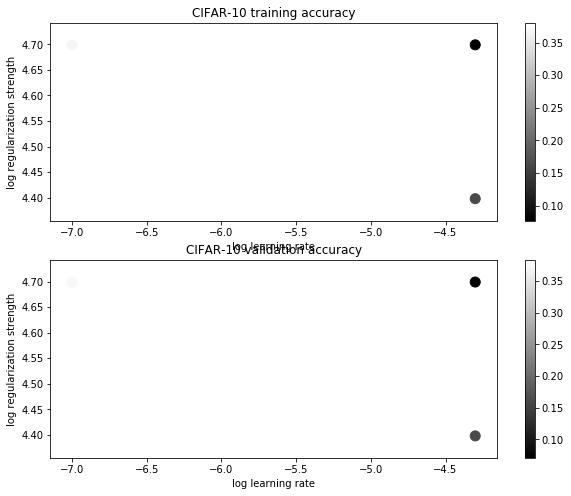

In [96]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [94]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.386000


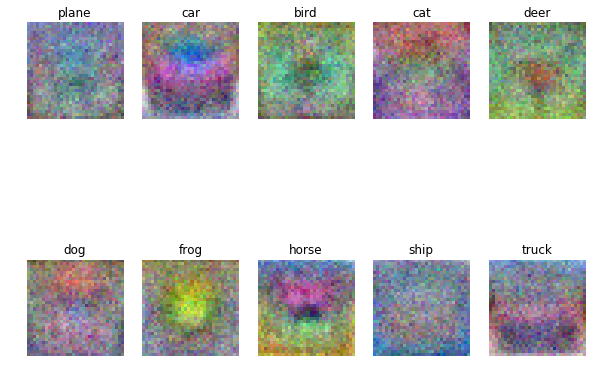

In [95]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*